In [14]:
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import pysal as ps

# Load GeoJSON and CSV data
geo_data = gpd.read_file("/content/india_district.geojson")
df = pd.read_csv('/content/soil.csv')


In [17]:
# Reproject GeoDataFrame to a projected CRS (e.g., UTM Zone 43N)
geo_data = geo_data.to_crs(epsg=32643)  # Use appropriate EPSG code for your region

# Preprocess data
geo_data['NAME_2'] = geo_data['NAME_2'].str.lower()
df['District '] = df['District '].str.lower()

# Merge GeoJSON with rainfall data
merged_data = geo_data.merge(df, left_on="NAME_2", right_on="District ")

merged_data = merged_data.dropna(subset=['Zn %', 'Fe%', 'Cu %', 'B %','S %'])

# Extract centroids in projected CRS
merged_data['centroid'] = merged_data.geometry.centroid
merged_data['latitude'] = merged_data['centroid'].y
merged_data['longitude'] = merged_data['centroid'].x

# Define features and target variable (e.g., Zn %)
X = merged_data[['latitude', 'longitude']]  # Add more features if needed
y = merged_data['Zn %']  # Target variable for Zn prediction


# Q1. Moran's I Autocorrelation

Mean Squared Error: 658.0661509493225
R-squared: 0.026358853571311958
Model Coefficients:
Intercept: 45.87943788867083
Coefficients: [ 7.83299457e-06 -6.25576598e-07]


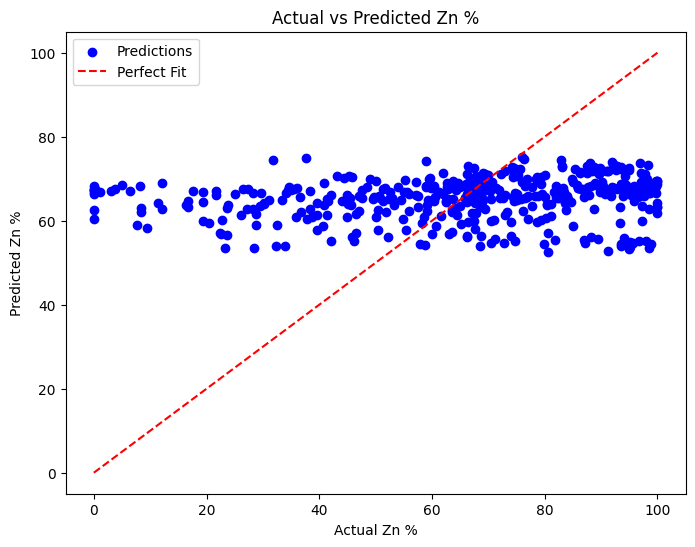

<ipython-input-20-afdcdf3d2ad2>:72: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(merged_data)


('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')
('WARNING: ', 305, ' is an island (no neighbors)')
('WARNING: ', 309, ' is an island (no neighbors)')
Global Moran's I: 0.2478942218838306
P-value for Moran's I: 0.001


/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 25, 26, 305, 309.
  W.__init__(self, neighbors, ids=ids, **kw)


In [20]:
import pandas as pd
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import libpysal
from esda import Moran
import matplotlib.pyplot as plt

# Load GeoJSON and CSV data
geo_data = gpd.read_file("/content/india_district.geojson")
df = pd.read_csv('/content/soil.csv')

# Reproject GeoDataFrame to a projected CRS (e.g., UTM Zone 43N)
geo_data = geo_data.to_crs(epsg=32643)  # Use appropriate EPSG code for your region

# Preprocess data
geo_data['NAME_2'] = geo_data['NAME_2'].str.lower()
df['District '] = df['District '].str.lower()

# Merge GeoJSON with rainfall data
merged_data = geo_data.merge(df, left_on="NAME_2", right_on="District ")

# Drop rows with missing values in key columns
merged_data = merged_data.dropna(subset=['Zn %', 'Fe%', 'Cu %', 'B %','S %'])

# Extract centroids in projected CRS
merged_data['centroid'] = merged_data.geometry.centroid
merged_data['latitude'] = merged_data['centroid'].y
merged_data['longitude'] = merged_data['centroid'].x

# Define features and target variable (e.g., Zn %)
X = merged_data[['latitude', 'longitude']]  # You can add more features if needed
y = merged_data['Zn %']  # Target variable for Zn prediction

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict Zn % for the entire dataset (not just the test set)
y_pred = model.predict(X)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared value
r_squared = model.score(X, y)
print(f"R-squared: {r_squared}")

# Coefficients of the model
print("Model Coefficients:")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

# Optional: Visualize the results (predictions vs actual values)
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, c='blue', label='Predictions')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Perfect Fit')
plt.xlabel('Actual Zn %')
plt.ylabel('Predicted Zn %')
plt.title('Actual vs Predicted Zn %')
plt.legend()
plt.show()

# Optional: Assessing the spatial relationship (Spatial Autocorrelation)
# Create a spatial weights matrix using Queen contiguity
w = libpysal.weights.Queen.from_dataframe(merged_data)

# Calculate Moran's I for global spatial autocorrelation on the residuals
residuals = y - y_pred  # Calculate residuals for the entire dataset
moran = Moran(residuals, w)

print(f"Global Moran's I: {moran.I}")
print(f"P-value for Moran's I: {moran.p_sim}")

# If Moran's I is significantly positive, this indicates spatial autocorrelation in the residuals.
# This could suggest that the linear model doesn't fully capture spatial patterns, and further spatial analysis may be required.


# Spatial Clustering

In [21]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load GeoJSON and CSV data
geo_data = gpd.read_file("/content/india_district.geojson")
df = pd.read_csv('/content/soil.csv')

# Reproject GeoDataFrame to a projected CRS (e.g., UTM Zone 43N)
geo_data = geo_data.to_crs(epsg=32643)

# Preprocess data
geo_data['NAME_2'] = geo_data['NAME_2'].str.lower()
df['District '] = df['District '].str.lower()

# Merge GeoJSON with rainfall data
merged_data = geo_data.merge(df, left_on="NAME_2", right_on="District ")

# Remove missing values for clustering
merged_data = merged_data.dropna(subset=['Zn %', 'Fe%', 'Cu %', 'B %','S %'])

# Extract centroids for clustering
merged_data['centroid'] = merged_data.geometry.centroid
merged_data['latitude'] = merged_data['centroid'].y
merged_data['longitude'] = merged_data['centroid'].x

# Choose features (latitude, longitude for spatial clustering)
X = merged_data[['latitude', 'longitude']]


## K-Means Clustering

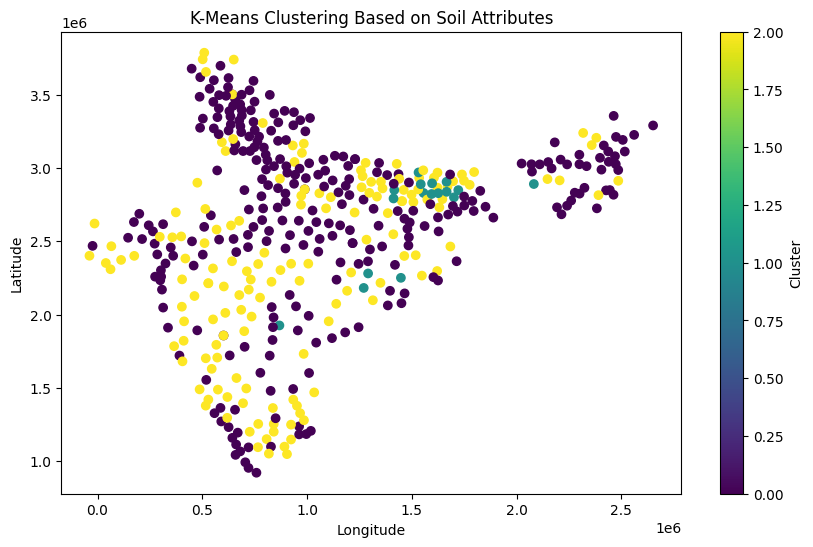

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt

# Select soil attributes for clustering (e.g., Zn %, Fe %, Cu %, etc.)
soil_attributes = merged_data[['Zn %', 'Fe%', 'Cu %', 'B %', 'S %']]

# Standardize the features (important for clustering algorithms like K-Means and DBSCAN)
scaler = StandardScaler()
soil_attributes_scaled = scaler.fit_transform(soil_attributes)

# K-Means Clustering with Soil Attributes
kmeans = KMeans(n_clusters=3, random_state=42)
merged_data['cluster_kmeans'] = kmeans.fit_predict(soil_attributes_scaled)

# Visualize the K-Means clustering results (using latitude and longitude for spatial visualization)
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['longitude'], merged_data['latitude'], c=merged_data['cluster_kmeans'], cmap='viridis', marker='o')
plt.title('K-Means Clustering Based on Soil Attributes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()

# **DBSCAN**

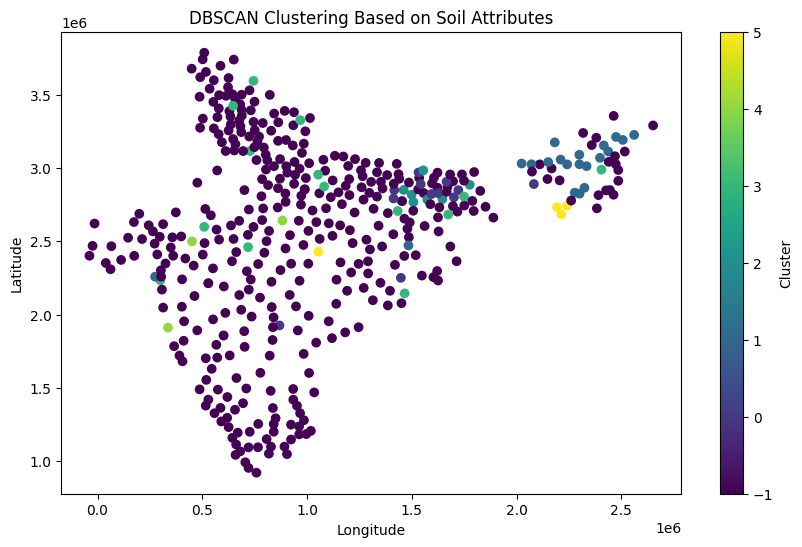

In [28]:
# DBSCAN Clustering with Soil Attributes
dbscan = DBSCAN(eps=0.3, min_samples=5)
merged_data['cluster_dbscan'] = dbscan.fit_predict(soil_attributes_scaled)

# Visualize the DBSCAN clustering results (using latitude and longitude for spatial visualization)
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['longitude'], merged_data['latitude'], c=merged_data['cluster_dbscan'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering Based on Soil Attributes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Cluster')
plt.show()